# Starbucks Capstone Challenge

In [173]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [174]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Analying and preparing dataset for training

## 1.1 Portfolio Dataset
contains offer ids and meta data about each offer (duration, type, etc.)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [175]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [176]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


There are only 10 entries in portfolio

In [177]:
# displaying all 10 rows
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [178]:
portfolio.groupby('offer_type').count()

,reward,channels,difficulty,duration,id
offer_type,,,,,
bogo,4,4,4,4,4
discount,4,4,4,4,4
informational,2,2,2,2,2


### 1.1.1 One-hot encoding offer_type and channels
There are 3 offer types <br>
- 4 bogo (buy one get one)
- 4 discount (get some amount off or percent off)
- 2 informational

For informational offer the reward is 0, so this feature might not appeal to customers to convert, so will remove any informational offers.

One-hot encoding on channels and offer_type

In [179]:
mlb = MultiLabelBinarizer()
channels_onehot = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

offertype_onehot = pd.get_dummies(portfolio['offer_type'])
portfolio_conv = pd.concat((portfolio, channels_onehot, offertype_onehot), axis=1)
portfolio_conv

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [180]:
# Drop channels & offer_type
portfolio_conv.drop(['channels','offer_type'], axis = 1, inplace=True)

# rename to offer_id
portfolio_conv.rename(columns={'id': 'offer_id'}, inplace=True)
portfolio_conv

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


## 1.2 Profile Dataset
demographic data for each customer

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [181]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [182]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


### 1.2.1 Dropping null values 

In [183]:
profile[profile['gender'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


From above we can see that most of the features like gender, age, income are None or NaN, so removing these rows since these won't be helpful while training the model

In [184]:
profile_conv = profile.dropna(axis=0)

profile_conv

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


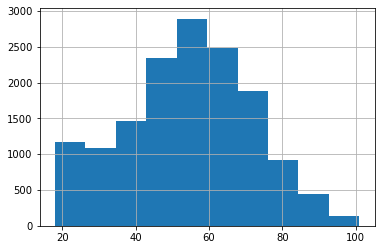

In [185]:
# Age distribution
profile_conv['age'].hist()

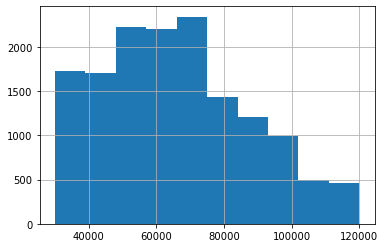

In [186]:
# income distribution
profile_conv['income'].hist()

### 1.2.2 Processing became_member_on - tenure

From **became_member_on** we can find the tenure, how long customer is with starbucks. 

In [187]:
profile_conv.groupby('became_member_on').count()

,gender,age,id,income
became_member_on,,,,
20130729,1,1,1,1
20130730,3,3,3,3
20130731,1,1,1,1
20130801,1,1,1,1
20130802,2,2,2,2
...,...,...,...,...
20180722,22,22,22,22
20180723,8,8,8,8
20180724,17,17,17,17


In [188]:
profile_conv['became_member_on'].apply(lambda x: str(x)[:4]).value_counts() 

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: became_member_on, dtype: int64

In given data, users became member from 2013 to 2018. To find tenure, number of days user is with starbucks, I will use 2019-01-01 

In [189]:
def convertDateToDays(dateint):
    to_date = datetime.strptime(str(dateint),'%Y%m%d')
    from_date = datetime.strptime('20190101','%Y%m%d')
    duration = from_date - to_date
    return duration.days

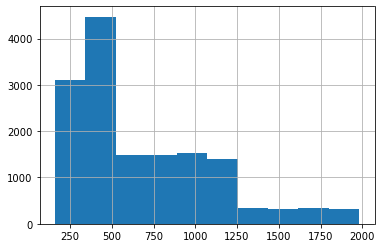

In [190]:
# Convert to number of days
profile_conv['tenure'] = profile_conv['became_member_on'].apply(lambda x: convertDateToDays(x))
profile_conv['tenure'].hist()

In [191]:
# drop became_member_on
profile_conv.drop('became_member_on', axis=1, inplace=True)

In [192]:
profile_conv.head()

,gender,age,id,income,tenure
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,535
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,602
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,250
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,326
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,416


### 1.2.3 Processing gender

In [193]:
profile_conv.groupby('gender').count()

,age,id,income,tenure
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


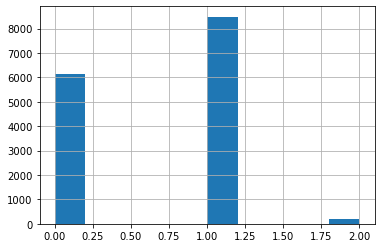

In [194]:
# Gender distribution
profile_conv['gender'].replace({'F':0,'M':1,'O':2}, inplace=True)
profile_conv['gender'].hist()

6129 females, 8464 males, others 212

In [195]:
profile_conv.rename(columns={'id': 'person_id'}, inplace=True)

profile_conv

,gender,age,person_id,income,tenure
1,0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,535
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,602
5,1,68,e2127556f4f64592b11af22de27a7932,70000.0,250
8,1,65,389bc3fa690240e798340f5a15918d5c,53000.0,326
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,416
...,...,...,...,...,...
16995,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,211
16996,1,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,172
16997,1,49,01d26f638c274aa0b965d24cefe3183f,73000.0,705
16998,0,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,1030


## 1.3 Transcript Dataset
records for transactions, offers received, offers viewed, and offers completed

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [196]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [197]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### 1.3.1 find any null values

In [198]:
transcript.dropna(axis=0)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


There are no null values

### 1.3.2 Removing informational transactions
Since informational offers are not helping to convert removing those

In [199]:
off_view_or_receive = transcript[(transcript['event'] == 'offer received') | (transcript['event'] == 'offer viewed')]

informational_offers = portfolio_conv[portfolio_conv['informational'] == 1]['offer_id'].values

inf_off_1 = off_view_or_receive[off_view_or_receive['value'] == {'offer id': informational_offers[0]}]
inf_off_2 = off_view_or_receive[off_view_or_receive['value'] == {'offer id': informational_offers[1]}]

transcript.drop(inf_off_1.index, inplace=True)
transcript.drop(inf_off_2.index, inplace=True)

In [200]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### 1.3.3 Processing transactional data

In [201]:
transaction_data = transcript[transcript['event'] == 'transaction']
transaction_data['amount'] = transaction_data['value'].apply(lambda x: x['amount'])
transaction_data.drop(['event', 'value'], axis=1, inplace=True)

transaction_data

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,a00058cf10334a308c68e7631c529907,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


In [202]:
# getting amount spent per customer
transaction_final = transaction_data.groupby('person').sum().drop('time', axis=1)
# getting number of transactions made by customer
transaction_final['no_of_trans'] = transaction_data.groupby('person').count().drop('time', axis=1)
# getting time spent in test by customer
transaction_final['time_spent_in_hrs'] = transaction_data.groupby('person').max().drop('amount', axis=1)

transaction_final

,amount,no_of_trans,time_spent_in_hrs
person,,,
0009655768c64bdeb2e877511632db8f,127.60,8,696
00116118485d4dfda04fdbaba9a87b5c,4.09,3,474
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,654
0020c2b971eb4e9188eac86d93036a77,196.86,8,708
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,672
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,580.98,11,552
fff7576017104bcc8677a8d63322b5e1,29.94,6,696
fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5,576


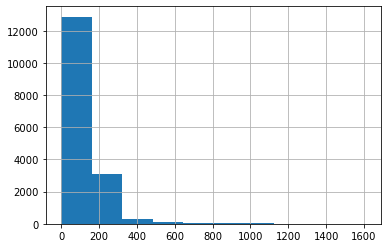

In [203]:
# Amount distribution
transaction_final['amount'].hist()

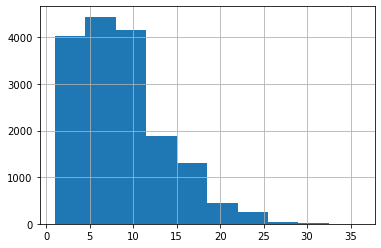

In [204]:
# number of transactions
transaction_final['no_of_trans'].hist()

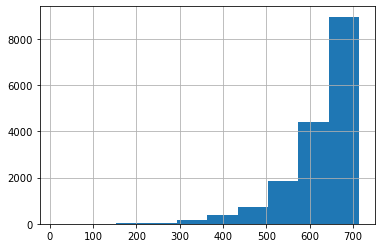

In [205]:
# time spent in test
transaction_final['time_spent_in_hrs'].hist()

In [206]:
transaction_final.reset_index(level=0, inplace=True)
transaction_final.rename(columns={'person': 'person_id'}, inplace=True)
transaction_final

,person_id,amount,no_of_trans,time_spent_in_hrs
0,0009655768c64bdeb2e877511632db8f,127.60,8,696
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3,474
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,654
3,0020c2b971eb4e9188eac86d93036a77,196.86,8,708
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,672
...,...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,580.98,11,552
16574,fff7576017104bcc8677a8d63322b5e1,29.94,6,696
16575,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5,576
16576,fffad4f4828548d1b5583907f2e9906b,88.83,12,678


In [207]:
# Removing transaction data
transcript.drop(transaction_data.index, axis=0, inplace=True)

### 1.3.4 processing offer received and viewed
Since offer completed will be the actual output event we are looking for, we can convert this to number of offers customer received and viewed

In [208]:
offer_received = pd.DataFrame(transcript[transcript['event'] == 'offer received'].groupby('person').count()['event'])
offer_received.reset_index(level=0, inplace=True)
offer_received

,person,event
0,0009655768c64bdeb2e877511632db8f,3
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,4
4,0020ccbbb6d84e358d3414a3ff76cffd,3
...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4
16924,fff7576017104bcc8677a8d63322b5e1,5
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2
16926,fffad4f4828548d1b5583907f2e9906b,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94866353d0>]],
      dtype=object)

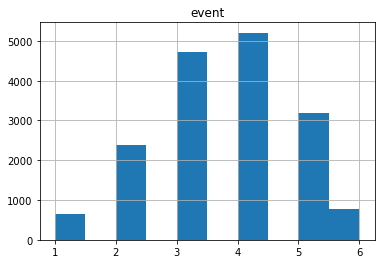

In [209]:
offer_received.hist()

In [210]:
offer_viewed = pd.DataFrame(transcript[transcript['event'] == 'offer viewed'].groupby('person').count()['event'])
offer_viewed.reset_index(level=0, inplace=True)
offer_viewed

,person,event
0,0009655768c64bdeb2e877511632db8f,2
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,2
4,0020ccbbb6d84e358d3414a3ff76cffd,3
...,...,...
16518,fff3ba4757bd42088c044ca26d73817a,2
16519,fff7576017104bcc8677a8d63322b5e1,4
16520,fff8957ea8b240a6b5e634b6ee8eafcf,2
16521,fffad4f4828548d1b5583907f2e9906b,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f948703c950>]],
      dtype=object)

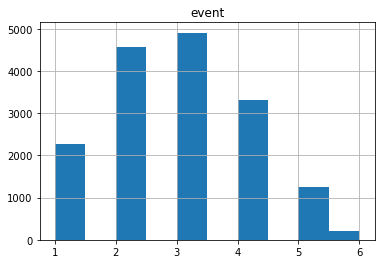

In [211]:
offer_viewed.hist()

Offer received is superset, all received offer, but only few people viewed or done transactions
- offer_received has 16928 records
- transaction_final has 16578 records
- offer_viewed has 16523

In [212]:
# renaming columns for merge
offer_received.rename(columns={'person': 'person_id', 'event': 'offers_received'}, inplace=True)
offer_viewed.rename(columns={'person': 'person_id', 'event': 'offers_viewed'}, inplace=True)

In [213]:
# merging offer_viewed to offer_received
offer_details = pd.merge(pd.merge(offer_received, offer_viewed, on='person_id', how="left"), \
         transaction_final, on='person_id', how="left")
offer_details

,person_id,offers_received,offers_viewed,amount,no_of_trans,time_spent_in_hrs
0,0009655768c64bdeb2e877511632db8f,3,2.0,127.60,8.0,696.0
1,00116118485d4dfda04fdbaba9a87b5c,2,2.0,4.09,3.0,474.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,79.46,5.0,654.0
3,0020c2b971eb4e9188eac86d93036a77,4,2.0,196.86,8.0,708.0
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,154.05,12.0,672.0
...,...,...,...,...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4,2.0,580.98,11.0,552.0
16924,fff7576017104bcc8677a8d63322b5e1,5,4.0,29.94,6.0,696.0
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2,2.0,12.15,5.0,576.0
16926,fffad4f4828548d1b5583907f2e9906b,3,3.0,88.83,12.0,678.0


In [214]:
offer_details.isnull().values.any()

True

Above is expected, since some records might not have offer recieved or transactions, so filling them with 0.

In [215]:
offer_details = offer_details.fillna(0)

offer_details.isnull().values.any()

False

In [216]:
# since we are done with offer received and offer viewed, drop those records
transcript.drop(transcript[transcript['event'] == 'offer received'].index, axis=0, inplace=True)
transcript.drop(transcript[transcript['event'] == 'offer viewed'].index, axis=0, inplace=True)

### 1.3.4 processing event
After processing transaction, offer received and offer viewed, now we look into offer completed data. There are 16928 members got offer, 16523 viewed the offer, 12774 persons completed offer. All this offer completed data has dictionary object which has what offer was completed and what reward was given to the user. 

In [217]:
transcript[transcript['event'] == 'offer completed'].groupby('person').count()['event']

person
0009655768c64bdeb2e877511632db8f    3
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    3
0020ccbbb6d84e358d3414a3ff76cffd    3
003d66b6608740288d6cc97a6903f4f0    3
                                   ..
fff29fb549084123bd046dbc5ceb4faa    6
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    3
fffad4f4828548d1b5583907f2e9906b    3
ffff82501cea40309d5fdd7edcca4a07    6
Name: event, Length: 12774, dtype: int64

16928 members got offer, 16523 viewed the offer,  12774 persons completed offer. 

In [218]:
transcript_conv = pd.concat((transcript, pd.get_dummies(transcript['event'])), axis=1)
transcript_conv

,person,event,value,time,offer completed
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,1
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,1
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,1
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,1
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,1
...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1


Seperating offer and rewards earned from value dictionary

In [219]:
transcript_conv['offer'] = transcript_conv['value'].apply(lambda x: x['offer_id'])
transcript_conv['reward_earned'] = transcript_conv['value'].apply(lambda x: x['reward'])
transcript_conv

,person,event,value,time,offer completed,offer,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10
...,...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1,fafdcd668e3743c1bb461111dcafc2a4,2
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1,fafdcd668e3743c1bb461111dcafc2a4,2


In [220]:
transcript_conv['reward_earned'] = transcript_conv['reward_earned'].fillna(0)
transcript_conv.head()

,person,event,value,time,offer completed,offer,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [221]:
# drop time, event, value columns
transcript_conv.drop(['time', 'event', 'value'], axis=1, inplace=True)

transcript_conv.rename(columns={'person': 'person_id', 'offer': 'offer_id'}, inplace=True)
transcript_conv.head()

,person_id,offer completed,offer_id,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10


## 1.4 Merging all above data into final data

### 1.4.1 Merging portfolio data and transcript data

In [222]:
transcript_conv = pd.merge(transcript_conv, portfolio_conv, on='offer_id')
transcript_conv

,person_id,offer completed,offer_id,reward_earned,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
1,73ffefd41e9a4ca3ab26b2b3697c6eb7,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
2,24115a61df25473e84a8a03f3c98de1a,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
3,2481f1fcfbcb4b288e5a03af02d95373,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
4,a45b69f1c8554ae7af83e74426ca437a,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33574,5cb65af515664bb0b39cdaa089244dc7,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0
33575,0dc85918181e4c3eb0e412d37fa8a552,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0
33576,f74033a8c6834303bd1b3ef0c98d11d8,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0
33577,f3e801caeafe4899b3b989b586e74ac7,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0


Grouping records so that we have only one entry for each user. Calculating count for columns to know how many emails, mobile, social, web, bogo, discount, offer completed happened for each user. And we also calcualted the sum of rewards earned, reward, difficulty and duration. 

In [223]:
transcript_conv = pd.merge(transcript_conv.groupby('person_id').count()\
    [['email', 'mobile', 'social', 'web', 'bogo', 'discount', 'offer completed']].reset_index(level=0),\
        transcript_conv.groupby('person_id').sum()\
  [['reward_earned', 'reward', 'difficulty', 'duration']].reset_index(level=0), on='person_id')

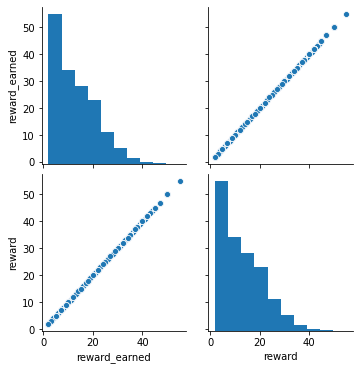

In [224]:
axes = sns.pairplot(transcript_conv[['reward_earned','reward']])

since both `reward` (given) and `reward_earned` both are same removing reward_earned 

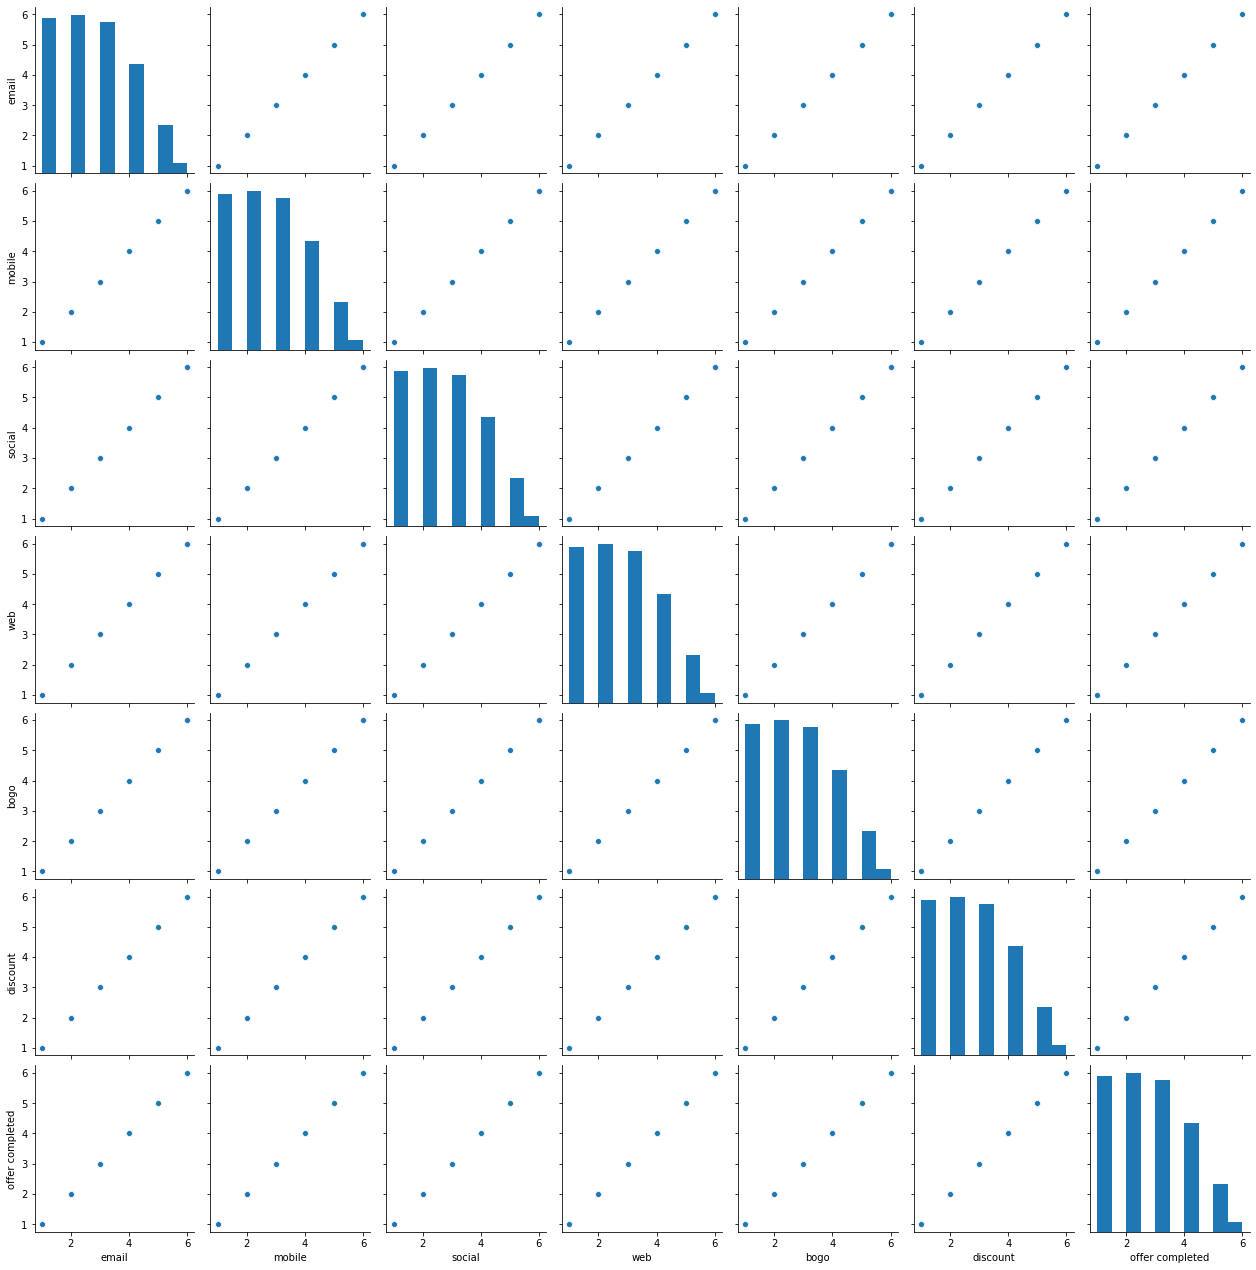

In [225]:
axes = sns.pairplot(transcript_conv[['email', 'mobile', 'social', 'web', 'bogo', 'discount', 'offer completed']])

Since email, mobile, social, web, bogo, discount, offer completed is matching and model will be aware of the output so removing this features - email, mobile, social, web, bogo, discount.

In [226]:
transcript_conv.drop(['reward_earned','email', 'mobile', 'social', 'web', 'bogo', 'discount'], axis=1, inplace=True)

### 1.4.2 merging offer details with transcript

In [227]:
final = pd.merge(offer_details, transcript_conv, on='person_id', how='left')

final.columns

Index(['person_id', 'offers_received', 'offers_viewed', 'amount',
       'no_of_trans', 'time_spent_in_hrs', 'offer completed', 'reward',
       'difficulty', 'duration'],
      dtype='object')

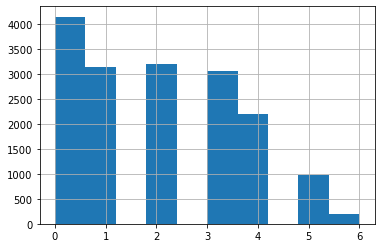

In [228]:
# fill 0 with those who have not completed the offer.
final['offer completed'] = final['offer completed'].fillna(0)
final['offer completed'].hist()

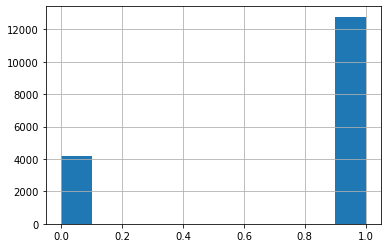

In [229]:
# Calculating output feature - offer_success - 0 means fails, 1 means completed
final['offer_success'] = final['offer completed'].apply(lambda x: 1 if x>0 else 0)
final['offer_success'].hist()

### 1.4.3 merging with profile data

In [230]:
# Merging profile data to transcript_conv
final = pd.merge(final, profile_conv, on='person_id', how='left')
final = final.fillna(0)

final

,person_id,offers_received,offers_viewed,amount,no_of_trans,time_spent_in_hrs,offer completed,reward,difficulty,duration,offer_success,gender,age,income,tenure
0,0009655768c64bdeb2e877511632db8f,3,2.0,127.60,8.0,696.0,3.0,9.0,25.0,22.0,1,1.0,33.0,72000.0,620.0
1,00116118485d4dfda04fdbaba9a87b5c,2,2.0,4.09,3.0,474.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,79.46,5.0,654.0,3.0,13.0,32.0,24.0,1,2.0,40.0,57000.0,357.0
3,0020c2b971eb4e9188eac86d93036a77,4,2.0,196.86,8.0,708.0,3.0,14.0,30.0,25.0,1,0.0,59.0,90000.0,1033.0
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,154.05,12.0,672.0,3.0,13.0,17.0,19.0,1,0.0,24.0,60000.0,781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4,2.0,580.98,11.0,552.0,3.0,9.0,25.0,24.0,1,0.0,69.0,83000.0,1199.0
16924,fff7576017104bcc8677a8d63322b5e1,5,4.0,29.94,6.0,696.0,3.0,9.0,25.0,27.0,1,1.0,71.0,73000.0,427.0
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2,2.0,12.15,5.0,576.0,0.0,0.0,0.0,0.0,0,1.0,71.0,56000.0,317.0
16926,fffad4f4828548d1b5583907f2e9906b,3,3.0,88.83,12.0,678.0,3.0,15.0,15.0,17.0,1,1.0,34.0,34000.0,708.0


In [231]:
final.columns

Index(['person_id', 'offers_received', 'offers_viewed', 'amount',
       'no_of_trans', 'time_spent_in_hrs', 'offer completed', 'reward',
       'difficulty', 'duration', 'offer_success', 'gender', 'age', 'income',
       'tenure'],
      dtype='object')

In [232]:
# drop person_id & offer completed
final.drop(['person_id', 'offer completed'], axis=1, inplace=True)
final.shape

(16928, 13)

The final data after processing all data, it has 16928 records with 12 features and 1 output feature <br>
1) offer_received - number of offers received <br>
2) offer_viewed - number of offers viewed <br>
3) amount - Amount spent till now<br>
4) no_of_trans - Number of transactions made <br>
5) time_spent_in_hrs - Time spent in hours in test<br>
6) reward - Total rewards received<br>
7) difficulty - Total number of amount spend to complete the offer<br>
8) duration - Total number of days offer was open<br>
9) gender - Customer Gender <br>
10) age - Customer age<br>
11) income - Customer Income <br>
12) tenure - Number of days user is with Starbucks<br>
Output feature - <br>
1) offer_success - User successfully completed the offer or not

In [235]:
final

,offers_received,offers_viewed,amount,no_of_trans,time_spent_in_hrs,reward,difficulty,duration,offer_success,gender,age,income,tenure
0,3,2.0,127.60,8.0,696.0,9.0,25.0,22.0,1,1.0,33.0,72000.0,620.0
1,2,2.0,4.09,3.0,474.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,3,3.0,79.46,5.0,654.0,13.0,32.0,24.0,1,2.0,40.0,57000.0,357.0
3,4,2.0,196.86,8.0,708.0,14.0,30.0,25.0,1,0.0,59.0,90000.0,1033.0
4,3,3.0,154.05,12.0,672.0,13.0,17.0,19.0,1,0.0,24.0,60000.0,781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,4,2.0,580.98,11.0,552.0,9.0,25.0,24.0,1,0.0,69.0,83000.0,1199.0
16924,5,4.0,29.94,6.0,696.0,9.0,25.0,27.0,1,1.0,71.0,73000.0,427.0
16925,2,2.0,12.15,5.0,576.0,0.0,0.0,0.0,0,1.0,71.0,56000.0,317.0
16926,3,3.0,88.83,12.0,678.0,15.0,15.0,17.0,1,1.0,34.0,34000.0,708.0


# 2. Split data for training and testing
Seperating offer success data and splitting data 70% for training and 30% for testing

In [236]:
X = final.drop('offer_success', axis=1)
y = pd.DataFrame(final['offer_success'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11849, 12)
(5079, 12)
(11849, 1)
(5079, 1)


In [237]:
# train success percent - 75%
y_train[y_train['offer_success'] == 1.0].count()/(y_train[y_train['offer_success'] == 0.0].count()\
                                                +y_train[y_train['offer_success'] == 1.0].count())

offer_success    0.756435
dtype: float64

In [238]:
# test success percent - 75%
y_test[y_test['offer_success'] == 1.0].count()/(y_test[y_test['offer_success'] == 0.0].count()\
                                                +y_test[y_test['offer_success'] == 1.0].count())

offer_success    0.750345
dtype: float64

Above shows in both train and test, success rate distribution is 75%

# 3. Benchmark using logistic regression
Will use Logistic regression which is extremely efficient mechanism for calculating probabilities especially incases like binary classifications. 

If z represents output of linear layer of a model trained with logistic regression, then sigmoid(z) will yield a value between 0 & 1.

$$y^{'} = \dfrac{1}{1 + e^{-z}}$$

$y^{'}$ is output of logistic regression model

z is $b + w_1x_1+w_2x_2+...+w_Nx_N$

In [239]:
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (NumPy array or pandas series)
    preds - the predictions for those values from some model (NumPy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('F1 score: ', format(f1_score(y_true, preds)))
        print('\n\n')
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(f1_score(y_true, preds)))
        print('\n\n')

In [240]:
#  Logistic regression is an extremely efficient mechanism for calculating probabilities
# https://developers.google.com/machine-learning/crash-course/logistic-regression/calculating-a-probability

logistic = LogisticRegression().fit(X_train, y_train)
logistic_preds = logistic.predict(X_test)
print_metrics(y_test, logistic_preds, 'logistic')

Accuracy score for logistic : 1.0
F1 score logistic : 1.0





# 4. Training the model

## 4.1 Using Naive Bayes 

In [241]:
# Instantiate our model
naive_bayes = MultinomialNB()

# Fit our model to the training data
naive_bayes.fit(X_train, y_train)

MultinomialNB()

## 4.2 Using sklearn ensembles

In [242]:
# Instantiate a BaggingClassifier with:
bagging_mod = BaggingClassifier()

# Instantiate a RandomForestClassifier with:
random_mod = RandomForestClassifier()

adaboost_mod = AdaBoostClassifier()

# Fit your BaggingClassifier to the training data
bagging_mod.fit(X_train, y_train)
random_mod.fit(X_train, y_train)
adaboost_mod.fit(X_train, y_train)

AdaBoostClassifier()

# 5. Testing the model

In [243]:
# Predict using Naive bayes on the test data
predictions = naive_bayes.predict(X_test)

# Predict using BaggingClassifier on the test data
bag_preds = bagging_mod.predict(X_test)

# Predict using RandomForestClassifier on the test data
rf_preds = random_mod.predict(X_test)

# Predict using AdaBoostClassifier on the test data
ada_preds = adaboost_mod.predict(X_test)

In [244]:
# Print Bagging scores
print_metrics(y_test, bag_preds, 'bagging')

# Pring Random Forest scores
print_metrics(y_test, rf_preds, 'random_forest')

# Print AdaBosst scores
print_metrics(y_test, ada_preds, 'adaboost')

# Print Bayes Classifier scores
print_metrics(y_test, predictions, 'naive_bayes')

Accuracy score for bagging : 1.0
F1 score bagging : 1.0



Accuracy score for random_forest : 1.0
F1 score random_forest : 1.0



Accuracy score for adaboost : 1.0
F1 score adaboost : 1.0



Accuracy score for naive_bayes : 0.9265603465249065
F1 score naive_bayes : 0.951602439340859





Naive Bayes gave accuracy score as 92% and F1 score as 95%.

Where as ensemble methods - bagging, random forest & adaboost gave 100% on accuracy & F1 score.

# 6. Refinement

Tuning Niave bayes using GridSearch. As ensemble methods matched benchmark model, no refinement needed. 

In [245]:
naive_bayes.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [246]:
grid_params = {
  'alpha': np.linspace(0.1, 1.5, 6),
  'fit_prior': [True, False],  
}
clf = GridSearchCV(naive_bayes, grid_params)
clf.fit(X_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.9436234199478852
Best Params:  {'alpha': 0.1, 'fit_prior': True}


# 7. Testing Robustness

After tunning, acucuracy increased from 92% to 94%

In [253]:
# Testing robustness
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
for seed in range(5, 50, 5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    naive_bayes = MultinomialNB(alpha=0.1)
    bagging_mod = BaggingClassifier()
    random_mod = RandomForestClassifier()
    adaboost_mod = AdaBoostClassifier()
    
    naive_bayes.fit(X_train, y_train)
    bagging_mod.fit(X_train, y_train)
    random_mod.fit(X_train, y_train)
    adaboost_mod.fit(X_train, y_train)
    
    predictions = naive_bayes.predict(X_test)
    bag_preds = bagging_mod.predict(X_test)
    rf_preds = random_mod.predict(X_test)
    ada_preds = adaboost_mod.predict(X_test)
    
    print_metrics(y_test, bag_preds, 'bagging with seed {}'.format(seed))
    print_metrics(y_test, rf_preds, 'random_forest with seed {}'.format(seed))
    print_metrics(y_test, ada_preds, 'adaboost with seed {}'.format(seed))
    print_metrics(y_test, predictions, 'naive_bayes with seed {}'.format(seed))

Accuracy score for bagging with seed 5 : 1.0
F1 score bagging with seed 5 : 1.0



Accuracy score for random_forest with seed 5 : 1.0
F1 score random_forest with seed 5 : 1.0



Accuracy score for adaboost with seed 5 : 1.0
F1 score adaboost with seed 5 : 1.0



Accuracy score for naive_bayes with seed 5 : 0.9523528253593228
F1 score naive_bayes with seed 5 : 0.9688063934003609



Accuracy score for bagging with seed 10 : 1.0
F1 score bagging with seed 10 : 1.0



Accuracy score for random_forest with seed 10 : 1.0
F1 score random_forest with seed 10 : 1.0



Accuracy score for adaboost with seed 10 : 1.0
F1 score adaboost with seed 10 : 1.0



Accuracy score for naive_bayes with seed 10 : 0.9470368182713133
F1 score naive_bayes with seed 10 : 0.9654818426793276



Accuracy score for bagging with seed 15 : 1.0
F1 score bagging with seed 15 : 1.0



Accuracy score for random_forest with seed 15 : 1.0
F1 score random_forest with seed 15 : 1.0



Accuracy score for adaboost with seed 15 :

# 8. Feature importance using Random Forest

In [248]:
feature_importances = pd.DataFrame(random_mod.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

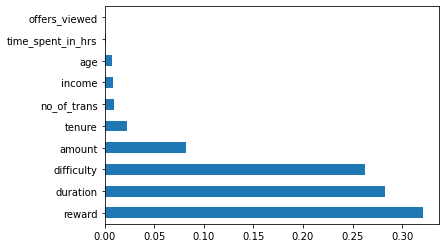

In [249]:
(pd.Series(random_mod.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh'))

# 9. Conclusion

Given user demographic data like gender, age etc and promotion data like duration or reward, logistic regression model gave 100% as benchmark model.<br>

When quickly checked with Naive Bayes, which initially gave 92% as accuracy but later on doing some refinement, accuracy came to 94%. <br>

When used sklearn ensemble methods like Ada Boost, Bagging and Random Forest was able to predict 100% of the time. 

By using feature importance, we can say that, below features played important role in offer to get complete 
- reward - how much reward was given on promotion. 
- duration - Total number of days offer was open.
- difficulty - minimum required spend to complete an offer.
- amount - How much user spent till now.
- tenure - How long user is with Starbucks.